# GTI770 - TP2

In [25]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import graphviz
import decimal
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers as opt

# import tensorflow as tf
# from tensorflow import keras

# from sklearn import tree
# from sklearn.naive_bayes import GaussianNB
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from mdlp.discretization import MDLP
# from sklearn.preprocessing import MinMaxScaler

In [2]:
#Utility methods
def SplitVectorData_Holdout(primitives_vector, train_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    
    val_portion = (1 - train_portion) / 2
    test_portion = (1 - train_portion) / 2

    nbTrain = int(size * train_portion)
    nbVal = int(size * val_portion)
    nbTest = int(size * test_portion)

    array_train = np.zeros((nbTrain, subsize), dtype=np.float64)
    array_val = np.zeros((nbVal, subsize), dtype=np.float64)
    array_test = np.zeros((nbTest, subsize), dtype=np.float64)

    array_train = primitives_vector[:nbTrain]
    array_val = primitives_vector[nbTrain : nbTrain + nbVal]
    array_test = primitives_vector[-nbTest:]
    return array_train, array_val, array_test

def SplitVectorData_KFold(primitives_vector, k, test_portion):
    
    size = len(primitives_vector)
    subsize = len(primitives_vector[0])
    subsetNb = int(size * (1 - test_portion) / k)
    testNb = int(size * test_portion)
    
    array_kfold_train = np.zeros((k, subsetNb, subsize), dtype=np.float64)
    array_kfold_test = np.zeros((testNb, subsize), dtype=np.float64)
    
    for i in range(0, k):
        if i == 0 :
            array_kfold_train[i] = primitives_vector[i * subsetNb]
        else :
            array_kfold_train[i] = primitives_vector[(i-1) * subsetNb : i * subsetNb]
    
    array_kfold_test = primitives_vector[-testNb:]

    return array_kfold_train, array_kfold_test

def concatenateWithoutTestPortion(full_array, index):
    result_array = []
    for i in range(0, len(full_array)):
        if len(result_array) == 0:
            result_array = full_array[i]
        elif i != index :
            result_array = np.concatenate((result_array, full_array[i]), axis=0)
    return result_array

def scores_mean(array_scores):
    
    size = len(array_scores)
    subsize = len(array_scores[0])
    array_mean = np.zeros(subsize, dtype=float)
    
    for i in range(0, size):
        for j in range(0, subsize):
            array_mean[j] += array_scores[i][j]
            
    for j in range(0, subsize):
            array_mean[j] = array_mean[j] / size
    
    return array_mean

def UseModelOnTestData(array, model, transformer=None):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)
    if transformer is not None:
        transform_train, transform_val, transform_test, Y_train, Y_val, Y_test = TransformData(array_train, array_val, array_test, len(array_train[0]), transformer)
    array_model_result, array_prediction_train_result, array_prediction_val_result, array_prediction_test_result, array_train_result, array_val_result, array_test_result = GenerateModelDataFromTransform(transform_train, transform_val, transform_test, Y_train, Y_val, Y_test, len(array[0]), model)
    result = [[array_test_result, array_prediction_test_result]]
    return GenerateScores(result) 

# ----- For debug -----
#Filter_train, Filter_val, Filter_test = SplitVectorDataTrainValTest(Filter, 0.6)
#print(len(Filter_train))
#print(len(Filter_val))
#print(len(Filter_test))
#print(len(Filter))
#----------------------

In [3]:
#Transforms and Models generation methods
def GenerateModelDataFromVector(array_train, array_val, array_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val = data_val[:,0:num_features]
    Y_val = data_val[:,num_features]
    
    data_test = array_test
    X_test = data_test[:,0:num_features]
    Y_test = data_test[:,num_features]
    
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

def TransformData(array_train, array_val, array_test, num_features, chosen_transformer):
    
    num_features = num_features - 1
    
    data_train = array_train
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]
    
    data_val = array_val
    X_val  = data_val[:,0:num_features]
    Y_val  = data_val[:,num_features]
    
    data_test = array_test
    X_test  = data_test[:,0:num_features]
    Y_test  = data_test[:,num_features]
    
    transformer_train = chosen_transformer
    transformer_train = transformer_train.fit_transform(X_train, Y_train)
    
    transformer_val = chosen_transformer
    transformer_val = transformer_val.fit_transform(X_val, Y_val)
    
    transformer_test = chosen_transformer
    transformer_test = transformer_test.fit_transform(X_test, Y_test)
    return transformer_train, transformer_val, transformer_test, Y_train, Y_val, Y_test

def GenerateModelDataFromTransform(array_train, array_val, array_test, y_train, y_val, y_test, num_features, chosen_model):
    
    num_features = num_features - 1
    
    X_train  = array_train
    Y_train = y_train
    
    X_val = array_val
    Y_val = y_val
    
    X_test  = array_test
    Y_test = y_test
    
    model = chosen_model
    model = model.fit(X_train, Y_train)
    prediction_train = model.predict(X_train)
    prediction_val = model.predict(X_val)
    prediction_test = model.predict(X_test)
    return model, prediction_train, prediction_val, prediction_test, Y_train, Y_val, Y_test

In [4]:
#display methods
def ExportTree(model):
    dot_data = tree.export_graphviz(model, out_file=None, 
                         #feature_names = ['', '', ''],  
                         class_names = ['spam', 'mail'],
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)
    graph.format = 'png'
    graph.render("Filter_data") 
    return graph

def GenerateScores(array):
    AccScores = np.zeros(len(array), dtype=float)
    F1Scores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
        F1Scores[i] = f1_score(array[i][0], array[i][1], average='weighted')
    
    return AccScores, F1Scores

def GenerateAccScores(array):
    AccScores = np.zeros(len(array), dtype=float)

    for i in range(0, len(array)):
        AccScores[i] = accuracy_score(array[i][0], array[i][1])
    
    return AccScores

#Extraction de primitive
def TracePlot(array_acc_X, array_acc_Y, array_f1_X, array_f1_Y, titre, titre_x, titre_y):        
    
    plt.plot(array_acc_X, array_acc_Y, 'ro')
    plt.plot(array_f1_X, array_f1_Y, 'g*')
    plt.xlabel(titre_x)
    plt.ylabel(titre_y)
    plt.legend(['Accuracy Score','F1 Score'])
    plt.title(titre)
    plt.grid(True)
    plt.show()

In [5]:
#model creations methods
def CreateDecisionTreeModel(depth):
    return tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=1)

def CreateKNNModel(k, weight):
    return KNeighborsClassifier(n_neighbors=k, weights=weight)

def CreateRandomForestModel(depth):
    return RandomForestClassifier(criterion='entropy', max_depth=depth, random_state=0)

In [6]:
#Decision tree methods
def DecisionTree_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
    array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

    validations = [[array_val_none, array_prediction_val_none],
    [array_val_3, array_prediction_val_3],
    [array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10]]

    return GenerateScores(validations)

def DecisionTree_KFold(array,k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(None))
        array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(3))
        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_tree_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(5))
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_tree_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateDecisionTreeModel(10))

        validations = [[array_val_none, array_prediction_val_none],
        [array_val_3, array_prediction_val_3],
        [array_val_5, array_prediction_val_5],
        [array_val_10, array_prediction_val_10]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores

    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)
    
    return accScores_mean, f1Scores_mean

In [7]:
#Bayes Methods
def Bayes_Holdout(array, array_prob ,array_transform=None):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)
    if array_transform is not None:
        array_train_tr, array_val_tr, array_test_tr = SplitVectorData_Holdout(array_transform, 0.6)

    transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
    transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=array_prob))
    if array_transform is not None:
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train_tr, array_val_tr, array_test_tr, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
    else:
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))

    array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
    array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


    validations = [[array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10],
    [array_val_mdlp, array_prediction_val_mdlp],
    [array_val_minmax, array_prediction_val_minmax]]

    return GenerateScores(validations)  
    
def Bayes_KFold(array, array_prob, k, array_transform=None):
    
    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    if array_transform is not None:
        array_kfold_train_tr, array_kfold_test_tr = SplitVectorData_KFold(array_transform, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test
        
        if array_transform is not None:
            array_train_tr = concatenateWithoutTestPortion(array_kfold_train_tr, i)
            array_val_tr = array_kfold_train_tr[i]
            array_test_tr = array_kfold_test_tr

        transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp = TransformData(array_train, array_val, array_test, len(array_train[0]), MDLP())
        transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax = TransformData(array_train, array_val, array_test, len(array_train[0]), MinMaxScaler())

        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), GaussianNB(priors=array_prob))
        if array_transform is not None:
            array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train_tr, array_val_tr, array_test_tr, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
        else:
            array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), MultinomialNB(fit_prior=True, class_prior=array_prob))
        array_model_mdlp, array_prediction_train_mdlp, array_prediction_val_mdlp, array_prediction_test_mdlp, array_train_mdlp, array_val_mdlp, array_test_mdlp = GenerateModelDataFromTransform(transform_train_mdlp, transform_val_mdlp, transform_test_mdlp, Y_train_mdlp, Y_val_mdlp, Y_test_mdlp, len(array[0]), MultinomialNB())
        array_model_minmax, array_prediction_train_minmax, array_prediction_val_minmax, array_prediction_test_minmax, array_train_minmax, array_val_minmax, array_test_minmax = GenerateModelDataFromTransform(transform_train_minmax, transform_val_minmax, transform_test_minmax, Y_train_minmax, Y_val_minmax, Y_test_minmax, len(array[0]), MultinomialNB())


        validations = [[array_val_5, array_prediction_val_5],
                     [array_val_10, array_prediction_val_10],
                     [array_val_mdlp, array_prediction_val_mdlp],
                     [array_val_minmax, array_prediction_val_minmax]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores 
        
    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)

    return accScores_mean, f1Scores_mean

In [8]:
#KNN Methods
def KNN_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
    array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
    array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
    array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
    array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
    array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

    validations_uniform = [[array_val_3u, array_prediction_val_3u],
                        [array_val_5u, array_prediction_val_5u],
                        [array_val_10u, array_prediction_val_10u]]

    validations_distance = [[array_val_3d, array_prediction_val_3d],
                        [array_val_5d, array_prediction_val_5d],
                        [array_val_10d, array_prediction_val_10d]]

    accScores_uniform, f1Scores_uniform = GenerateScores(validations_uniform)
    accScores_distance, f1Scores_dsitance = GenerateScores(validations_distance)

    return accScores_uniform, f1Scores_uniform, accScores_distance, f1Scores_dsitance
    
def KNN_KFold(array, k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores_uniform = np.zeros((k, 3), dtype=float)
    all_f1Scores_uniform = np.zeros((k, 3), dtype=float)
    all_accScores_distance = np.zeros((k, 3), dtype=float)
    all_f1Scores_distance = np.zeros((k, 3), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_3u, array_prediction_train_3u, array_prediction_val_3u, array_prediction_test_3u, array_train_3u, array_val_3u, array_test_3u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'uniform'))
        array_model_5u, array_prediction_train_5u, array_prediction_val_5u, array_prediction_test_5u, array_train_5u, array_val_5u, array_test_5u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'uniform'))
        array_model_10u, array_prediction_train_10u, array_prediction_val_10u, array_prediction_test_10u, array_train_10u, array_val_10u, array_test_10u = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'uniform'))
        array_model_3d, array_prediction_train_3d, array_prediction_val_3d, array_prediction_test_3d, array_train_3d, array_val_3d, array_test_3d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(3, 'distance'))
        array_model_5d, array_prediction_train_5d, array_prediction_val_5d, array_prediction_test_5d, array_train_5d, array_val_5d, array_test_5d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(5, 'distance'))
        array_model_10d, array_prediction_train_10d, array_prediction_val_10d, array_prediction_test_10d, array_train_10d, array_val_10d, array_test_10d = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateKNNModel(10, 'distance'))

        validations_uniform = [[array_val_3u, array_prediction_val_3u],
        [array_val_5u, array_prediction_val_5u],
        [array_val_10u, array_prediction_val_10u]]

        validations_distance = [[array_val_3d, array_prediction_val_3d],
        [array_val_5d, array_prediction_val_5d],
        [array_val_10d, array_prediction_val_10d]]

        Array_AccScores_uniform, Array_F1Scores_uniform = GenerateScores(validations_uniform)
        Array_AccScores_distance, Array_F1Scores_distance = GenerateScores(validations_distance)

        all_accScores_uniform[i] = Array_AccScores_uniform
        all_f1Scores_uniform[i] = Array_F1Scores_uniform
        all_accScores_distance[i] = Array_AccScores_distance
        all_f1Scores_distance[i] = Array_F1Scores_distance

    accScores_mean_uniform = scores_mean(all_accScores_uniform)
    f1Scores_mean_uniform = scores_mean(all_f1Scores_uniform)
    accScores_mean_distance = scores_mean(all_accScores_distance)
    f1Scores_mean_distance = scores_mean(all_f1Scores_distance)

    return accScores_mean_uniform, f1Scores_mean_uniform, accScores_mean_distance, f1Scores_mean_distance

In [9]:
#Random forest methods
def RandomForest_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)

    array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(None))
    array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(3))
    array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(5))
    array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(10))

    validations = [[array_val_none, array_prediction_val_none],
    [array_val_3, array_prediction_val_3],
    [array_val_5, array_prediction_val_5],
    [array_val_10, array_prediction_val_10]]

    return GenerateScores(validations)

def RandomForest_KFold(array,k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 4), dtype=float)
    all_f1Scores = np.zeros((k, 4), dtype=float)

    for i in range(1, k):

        array_train = concatenateWithoutTestPortion(array_kfold_train, i)
        array_val = array_kfold_train[i]
        array_test = array_kfold_test

        array_model_none, array_prediction_train_none, array_prediction_val_none, array_prediction_test_none, array_train_none, array_val_none, array_test_none = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(None))
        array_model_3, array_prediction_train_3, array_prediction_val_3, array_prediction_test_3, array_train_3, array_val_3, array_test_3 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(3))
        array_model_5, array_prediction_train_5, array_prediction_val_5, array_prediction_test_tree_5, array_train_5, array_val_5, array_test_5 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(5))
        array_model_10, array_prediction_train_10, array_prediction_val_10, array_prediction_test_tree_10, array_train_10, array_val_10, array_test_10 = GenerateModelDataFromVector(array_train, array_val, array_test, len(array[0]), CreateRandomForestModel(10))

        validations = [[array_val_none, array_prediction_val_none],
        [array_val_3, array_prediction_val_3],
        [array_val_5, array_prediction_val_5],
        [array_val_10, array_prediction_val_10]]

        Array_AccScores, Array_F1Scores = GenerateScores(validations)

        all_accScores[i] = Array_AccScores
        all_f1Scores[i] = Array_F1Scores

    accScores_mean = scores_mean(all_accScores)
    f1Scores_mean = scores_mean(all_f1Scores)
    
    return accScores_mean, f1Scores_mean

In [10]:
# accScores_filter_tree_holdout, f1Scores_filter_tree_holdout = DecisionTree_Holdout(Filter)
# accScores_filter_tree_kfold, f1Scores_filter_tree_kfold = DecisionTree_KFold(Filter,10)
# accScores_filter_bayes_holdout, f1Scores_filter_bayes_holdout = Bayes_Holdout(Filter, [0.4003,0.5997])
# accScores_filter_bayes_kfold, f1Scores_filter_bayes_kfold = Bayes_KFold(Filter, [0.4003,0.5997], 10)
# accScores_filter_knn_holdout_uniform, f1Scores_filter_knn_holdout_uniform, accScores_filter_knn_holdout_distance, f1Scores_filter_knn_holdout_distance = KNN_Holdout(Filter)
# accScores_filter_knn_kfold_uniform, f1Scores_filter_knn_kfold_uniform, accScores_filter_knn_kfold_distance, f1Scores_filter_knn_kfold_distance = KNN_KFold(Filter, 10) 
# accScores_filter_test, f1Scores_filter_test = UseModelOnTestData(Filter, MultinomialNB(), MinMaxScaler())
# accScores_filter_forest_holdout, f1Scores_filter_forest_holdout = RandomForest_Holdout(Filter)
# accScores_filter_forest_kfold, f1Scores_filter_forest_kfold = RandomForest_KFold(Filter,10)

### Galaxies

In [42]:
# Get some galaxies
fid = open('galaxy_feature_vectors.csv', 'r') 

NbGalaxy = 16000 #16000
Galaxies = np.zeros((NbGalaxy, 7), dtype=np.float64)

count = 0
count_smooth = 0
count_spiral = 0

for line in fid:
    element = line.rstrip('\n').split(',')
    
    label = float(element[75])
    
    if label == 0.0 and count_smooth < NbGalaxy/2:
        count_smooth += 1     
    elif label == 1.0 and count_spiral < NbGalaxy/2:
        count_spiral += 1
    else:
        continue

    Galaxies[count] = [element[4], element[5], element[6], element[17], element[23], element[24], element[75]]
        
    count += 1
    if count >= NbGalaxy:
        break

fid.close() 

# ----- For debug -----
#print(count_smooth)
#print(count_spiral)
#print(count)
#print(Galaxies)
#----------------------

In [12]:
def NormalizeData(data):
    transform = MinMaxScaler()
    return transform.fit_transform(data, data[:,len(Galaxies[0])-1])

def GetGalaxiesClassProbabilities():
    count_smooth = 0
    count_spiral = 0
    
    fid = open('galaxy_feature_vectors.csv', 'r') 
    for line in fid:
        element = line.rstrip('\n').split(',')

        label = float(element[75])

        if label == 0.0:
            count_smooth += 1     
        elif label == 1.0:
            count_spiral += 1
    return [count_smooth/(count_smooth+count_spiral), count_spiral/(count_smooth+count_spiral)]

Train on 9600 samples, validate on 3200 samples
Epoch 1/60
9600/9600 [==============================] - 2s 158us/step - loss: 0.6972 - acc: 0.5152 - val_loss: 0.6934 - val_acc: 0.5181
Epoch 2/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6945 - acc: 0.5094 - val_loss: 0.6925 - val_acc: 0.5181
Epoch 3/60
9600/9600 [==============================] - 0s 36us/step - loss: 0.6939 - acc: 0.5096 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 4/60
9600/9600 [==============================] - 0s 35us/step - loss: 0.6933 - acc: 0.5178 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 5/60
9600/9600 [==============================] - 0s 36us/step - loss: 0.6927 - acc: 0.5148 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 6/60
9600/9600 [==============================] - 0s 33us/step - loss: 0.6928 - acc: 0.5178 - val_loss: 0.6923 - val_acc: 0.5181
Epoch 7/60
9600/9600 [==============================] - 0s 35us/step - loss: 0.6924 - acc: 0.5203 - val_loss: 0.6923 - val_acc: 0.5181
Epoch 

3200/3200 [==============================] - 0s 41us/step
Train on 9600 samples, validate on 3200 samples
Epoch 1/60
9600/9600 [==============================] - 1s 147us/step - loss: 0.6941 - acc: 0.5132 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 2/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6925 - acc: 0.5202 - val_loss: 0.6921 - val_acc: 0.5181
Epoch 3/60
9600/9600 [==============================] - 0s 37us/step - loss: 0.6923 - acc: 0.5194 - val_loss: 0.6920 - val_acc: 0.5181
Epoch 4/60
9600/9600 [==============================] - 0s 35us/step - loss: 0.6919 - acc: 0.5212 - val_loss: 0.6919 - val_acc: 0.5181
Epoch 5/60
9600/9600 [==============================] - 0s 35us/step - loss: 0.6921 - acc: 0.5199 - val_loss: 0.6917 - val_acc: 0.5181
Epoch 6/60
9600/9600 [==============================] - 0s 36us/step - loss: 0.6918 - acc: 0.5198 - val_loss: 0.6916 - val_acc: 0.5181
Epoch 7/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6919

3200/3200 [==============================] - 0s 32us/step
Train on 9600 samples, validate on 3200 samples
Epoch 1/60
9600/9600 [==============================] - 1s 150us/step - loss: 0.6962 - acc: 0.5181 - val_loss: 0.6925 - val_acc: 0.5181
Epoch 2/60
9600/9600 [==============================] - 0s 35us/step - loss: 0.6923 - acc: 0.5204 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 3/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6925 - acc: 0.5204 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 4/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6922 - acc: 0.5204 - val_loss: 0.6926 - val_acc: 0.5181
Epoch 5/60
9600/9600 [==============================] - 0s 33us/step - loss: 0.6922 - acc: 0.5204 - val_loss: 0.6923 - val_acc: 0.5181
Epoch 6/60
9600/9600 [==============================] - 0s 33us/step - loss: 0.6923 - acc: 0.5204 - val_loss: 0.6924 - val_acc: 0.5181
Epoch 7/60
9600/9600 [==============================] - 0s 34us/step - loss: 0.6920

9600/9600 [==============================] - 0s 34us/step - loss: 0.4777 - acc: 0.7834 - val_loss: 0.4686 - val_acc: 0.7928
Epoch 60/60
3200/3200 [==============================] - 0s 28us/step


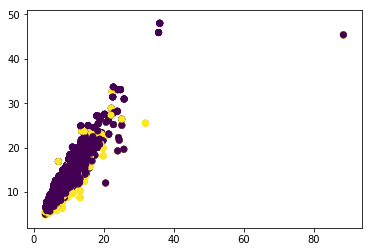

In [73]:
def SplitLabelsFromPrimitives(data_train, data_val, data_test):
    num_features = len(data_train[0]) - 1
    
    X_train  = data_train[:,0:num_features]
    Y_train  = data_train[:,num_features]

    X_val  = data_val[:,0:num_features]
    Y_val  = data_val[:,num_features]

    X_test  = data_test[:,0:num_features]
    Y_test  = data_test[:,num_features]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def GenerateModel(data_train, data_val, data_test, layers, perceptrons, epochs, learnRate, name):
    
    #Split labels from the primitives
    X_train, Y_train, X_val, Y_val, X_test, Y_test = SplitLabelsFromPrimitives(data_train, data_val, data_test)
    
    #Create model
    model = Sequential()

    #Add layers
    model.add(Dense(units=perceptrons, activation='sigmoid', input_shape=(len(X_train[0]),)))
    model.add(Dropout(0.2))
    for i in range(0, layers - 2):
        model.add(Dense(units=perceptrons, activation='sigmoid'))
        model.add(Dropout(0.2))
    model.add(Dense(units=2, activation='sigmoid'))
    
    #Set optimizers and compile
    sgd = opt.SGD(lr=learnRate, decay=0, momentum=0, nesterov=False)
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= sgd,
              metrics=['accuracy'])
    
    #Use TensorBoard
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/'+name)
    
    #Train
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=100, callbacks=[tb_callback])
    
    model.evaluate(X_test, Y_test)
    
    Y_probs = model.predict(X_test)
    
    Y_pred = Y_probs.argmax(axis=1)
    
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_pred)
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test)

    return Y_test, Y_pred

def Neurone_Holdout(array):
    array_train, array_val, array_test = SplitVectorData_Holdout(array, 0.6)
    
    AccScores = np.zeros(13, dtype=float)
    
    #base
    y_true_base, y_pred_base = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.0005, 'base')
    
    #perceptrons
    y_true_perc1, y_pred_perc1 = GenerateModel(array_train, array_val, array_test, 4, 50, 60, 0.0005, 'perc1')
    y_true_perc2, y_pred_perc2 = GenerateModel(array_train, array_val, array_test, 4, 300, 60, 0.0005, 'perc2')
    y_true_perc3, y_pred_perc3 = GenerateModel(array_train, array_val, array_test, 4, 600, 60, 0.0005, 'perc3')

    #epochs
    y_true_epoch1, y_pred_epoch1 = GenerateModel(array_train, array_val, array_test, 4, 100, 30, 0.0005, 'epoch1')
    y_true_epoch2, y_pred_epoch2 = GenerateModel(array_train, array_val, array_test, 4, 100, 120, 0.0005, 'epoch2')
    y_true_epoch3, y_pred_epoch3 = GenerateModel(array_train, array_val, array_test, 4, 100, 240, 0.0005, 'epoch3')
    
    #layers
    y_true_layer1, y_pred_layer1 = GenerateModel(array_train, array_val, array_test, 6, 100, 60, 0.0005, 'layer1')
    y_true_layer2, y_pred_layer2 = GenerateModel(array_train, array_val, array_test, 12, 100, 60, 0.0005, 'layer2')
    y_true_layer3, y_pred_layer3 = GenerateModel(array_train, array_val, array_test, 24, 100, 60, 0.0005, 'layer3')
    
    learning rate
    y_true_lr1, y_pred_lr1 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.1, 'lr1')
    y_true_lr2, y_pred_lr2 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.5, 'lr2')
    y_true_lr3, y_pred_lr3 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 1, 'lr3')

    validations = [[y_true_base, y_pred_base],
    [y_true_perc1, y_pred_perc1],
    [y_true_perc2, y_pred_perc2],
    [y_true_perc3, y_pred_perc3],
    [y_true_epoch1, y_pred_epoch1],
    [y_true_epoch2, y_pred_epoch2],
    [y_true_epoch3, y_pred_epoch3],
    [y_true_layer1, y_pred_epoch1],
    [y_true_layer2, y_pred_layer2],
    [y_true_layer3, y_pred_layer3],
    [y_true_lr1, y_pred_lr1],
    [y_true_lr2, y_pred_lr2],
    [y_true_lr3, y_pred_lr3]]
    
    return GenerateAccScores(validations)
    
def Neurone_KFold(array,k):

    array_kfold_train, array_kfold_test = SplitVectorData_KFold(array, k, 0.2)
    all_accScores = np.zeros((k, 13), dtype=float)
    all_f1Scores = np.zeros((k, 13), dtype=float)

    for i in range(1, k):

        #base
        y_true_base, y_pred_base = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.0005, 'kfold/k'+i+'_base')

        #perceptrons
        y_true_perc1, y_pred_perc1 = GenerateModel(array_train, array_val, array_test, 4, 50, 60, 0.0005, 'kfold/k'+i+'_perc1')
        y_true_perc2, y_pred_perc2 = GenerateModel(array_train, array_val, array_test, 4, 300, 60, 0.0005, 'kfold/k'+i+'_perc2')
        y_true_perc3, y_pred_perc3 = GenerateModel(array_train, array_val, array_test, 4, 600, 60, 0.0005, 'kfold/k'+i+'_perc3')

        #epochs
        y_true_epoch1, y_pred_epoch1 = GenerateModel(array_train, array_val, array_test, 4, 100, 30, 0.0005, 'kfold/k'+i+'_epoch1')
        y_true_epoch2, y_pred_epoch2 = GenerateModel(array_train, array_val, array_test, 4, 100, 120, 0.0005, 'kfold/k'+i+'_epoch2')
        y_true_epoch3, y_pred_epoch3 = GenerateModel(array_train, array_val, array_test, 4, 100, 240, 0.0005, 'kfold/k'+i+'_epoch3')

        #layers
        y_true_layer1, y_pred_layer1 = GenerateModel(array_train, array_val, array_test, 6, 100, 60, 0.0005, 'kfold/k'+i+'_layer1')
        y_true_layer2, y_pred_layer2 = GenerateModel(array_train, array_val, array_test, 12, 100, 60, 0.0005, 'kfold/k'+i+'_layer2')
        y_true_layer3, y_pred_layer3 = GenerateModel(array_train, array_val, array_test, 24, 100, 60, 0.0005, 'kfold/k'+i+'_layer3')

        learning rate
        y_true_lr1, y_pred_lr1 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.1, 'kfold/k'+i+'_lr1')
        y_true_lr2, y_pred_lr2 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 0.5, 'kfold/k'+i+'_lr2')
        y_true_lr3, y_pred_lr3 = GenerateModel(array_train, array_val, array_test, 4, 100, 60, 1, 'kfold/k'+i+'_lr3')

        validations = [[y_true_base, y_pred_base],
        [y_true_perc1, y_pred_perc1],
        [y_true_perc2, y_pred_perc2],
        [y_true_perc3, y_pred_perc3],
        [y_true_epoch1, y_pred_epoch1],
        [y_true_epoch2, y_pred_epoch2],
        [y_true_epoch3, y_pred_epoch3],
        [y_true_layer1, y_pred_epoch1],
        [y_true_layer2, y_pred_layer2],
        [y_true_layer3, y_pred_layer3],
        [y_true_lr1, y_pred_lr1],
        [y_true_lr2, y_pred_lr2],
        [y_true_lr3, y_pred_lr3]]

        Array_AccScores = GenerateAccScores(validations)

        all_accScores[i] = Array_AccScores

    accScores_mean = scores_mean(all_accScores)
    
    return accScores_mean

#accScores_neurone_holdout = Neurone_Holdout(Galaxies)
#accScores_neurone_kfold = Neurone_KFold(Galaxies, 10)
